# Running FLiES for an ECOSTRESS Scene

This is an example of running the artificial neural network emulator of the Forest Light Environmental Simulator (FLiES) corresponding to an ECOsystem Spaceborne Thermal Radiometer Experiment on Space Station (ECOSTRESS) scene.

In [1]:
from os.path import join
from datetime import datetime, date, time
from dateutil import parser
import rasters as rt
from geos5fp import GEOS5FP
from koppengeiger import load_koppen_geiger
from solar_apparent_time import UTC_to_solar
import sun_angles
from FLiESANN import process_FLiES
from matplotlib.colors import LinearSegmentedColormap
import logging
logging.disable(logging.CRITICAL)

Here's an example ECOSTRESS surface temperature scene.

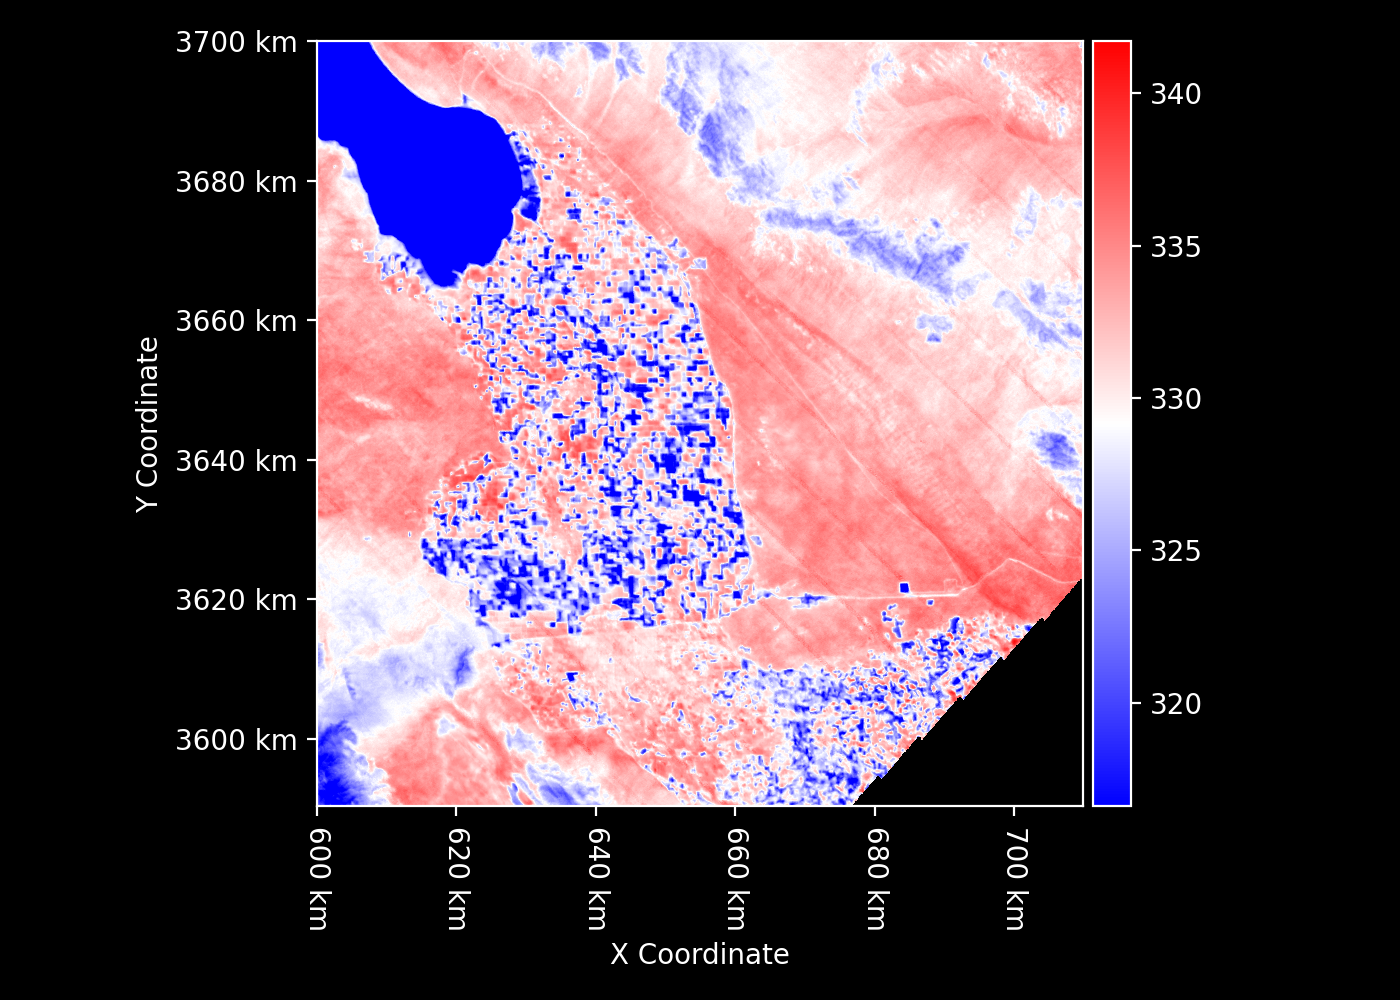

In [2]:
ST_filename = "ECOv002_L2T_LSTE_34366_004_11SPS_20240728T204025_0712_01_LST.tif"
ST_cmap = "bwr"
ST = rt.Raster.open(ST_filename, cmap=ST_cmap)
ST

Let's get the acquisition time of the scene.

In [3]:
time_UTC = parser.parse(ST_filename.split("_")[6])
longitude = ST.geometry.centroid_latlon.x
latitude = ST.geometry.centroid_latlon.y
time_solar = UTC_to_solar(time_UTC, longitude)
doy_solar = time_solar.timetuple().tm_yday
hour_of_day_solar = time_solar.hour + time_solar.minute / 60 + time_solar.second / 3600
print(f"{time_UTC:%Y-%m-%d %H:%M:%S} UTC")
print(f"{time_solar:%Y-%m-%d %H:%M:%S} solar apparent time at longitude {longitude}")
print(f"day of year {doy_solar} at longitude {longitude}")
print(f"hour of day {hour_of_day_solar} at longitude {longitude}")


2024-07-28 20:40:25 UTC
2024-07-28 12:59:02 solar apparent time at longitude -115.3433725031462
day of year 210 at longitude -115.3433725031462
hour of day 12.983888888888888 at longitude -115.3433725031462


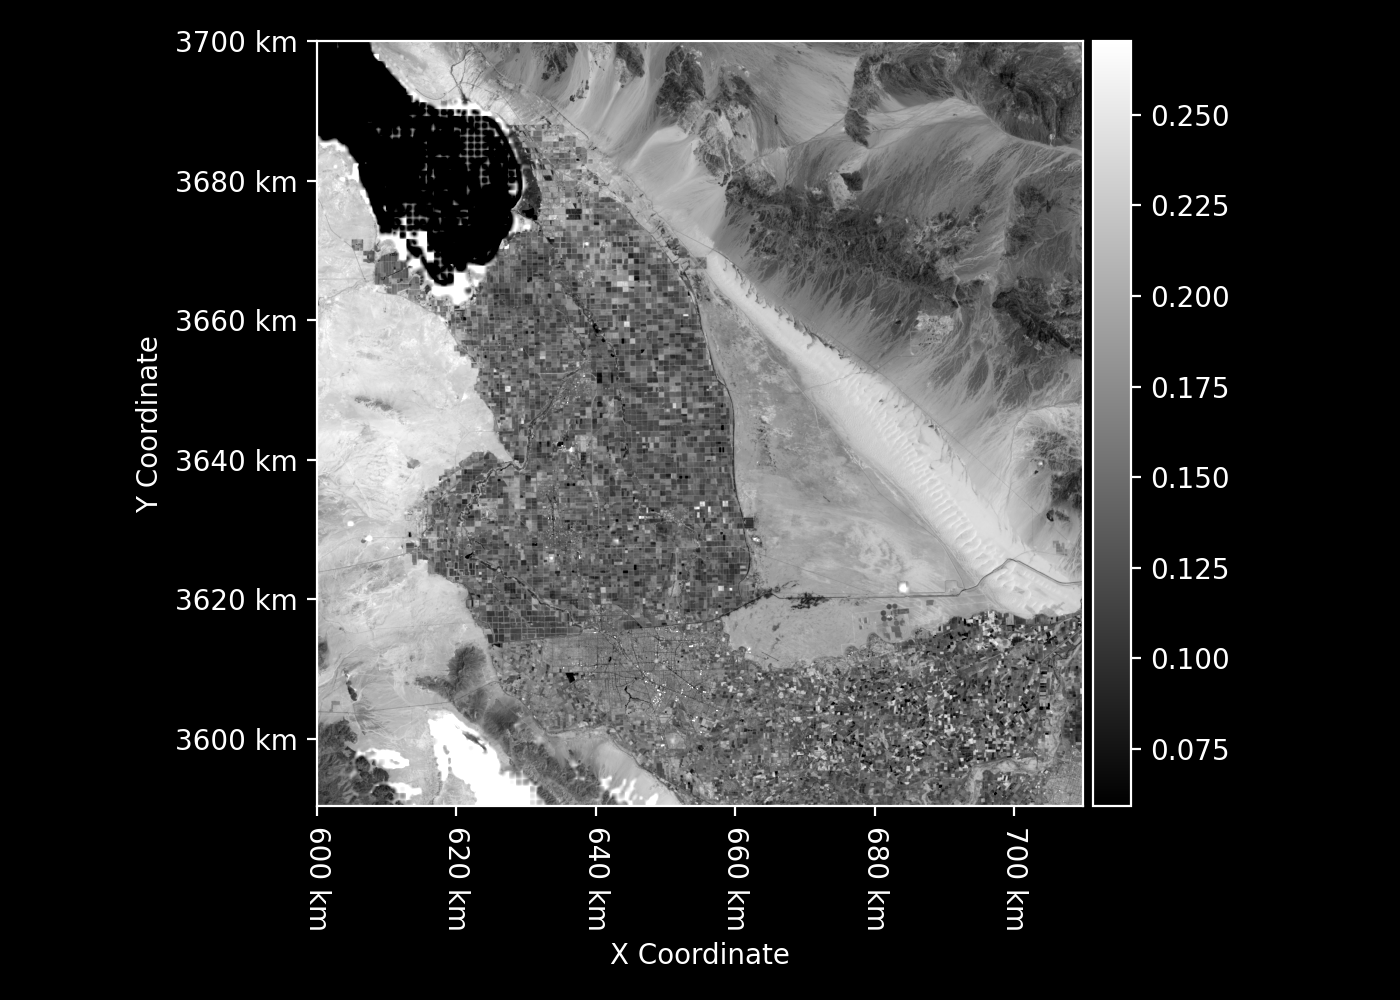

In [4]:
albedo_filename = "ECOv002_L2T_STARS_11SPS_20240728_0712_01_albedo.tif"
albedo_cmap = LinearSegmentedColormap.from_list(name="albedo", colors=["black", "white"])
albedo = rt.Raster.open(albedo_filename, cmap=albedo_cmap)
albedo

We'll use the `geos5fp` package to generate rasters of aerosol optical thickness (AOT) and cloud optical thickness (COT).

In [5]:
geos5fp = GEOS5FP(working_directory=join("~", "data", "GEOS5FP"))

Download AOT from GEOS-5 FP.

In [6]:
%%capture
AOT = geos5fp.AOT(time_UTC=time_UTC, geometry=albedo.geometry)

--2024-09-13 21:36:24--  https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/das/Y2024/M07/D28/GEOS.fp.asm.tavg3_2d_aer_Nx.20240728_1930.V01.nc4
Resolving portal.nccs.nasa.gov (portal.nccs.nasa.gov)... 2001:4d0:2418:2800::a99a:9791, 169.154.151.145
Connecting to portal.nccs.nasa.gov (portal.nccs.nasa.gov)|2001:4d0:2418:2800::a99a:9791|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121756523 (116M) [application/octet-stream]
Saving to: ‘/Users/gregoryhalverson/data/GEOS5FP/GEOS5FP_download_directory/2024.07.28/GEOS.fp.asm.tavg3_2d_aer_Nx.20240728_1930.V01.nc4.20240914043624.download’

     0K .......... .......... .......... .......... ..........  0%  215K 9m13s
    50K .......... .......... .......... .......... ..........  0%  558K 6m23s
   100K .......... .......... .......... .......... ..........  0% 1.73M 4m38s
   150K .......... .......... .......... .......... ..........  0%  661K 4m13s
   200K .......... .......... .......... .......... ..........  0%

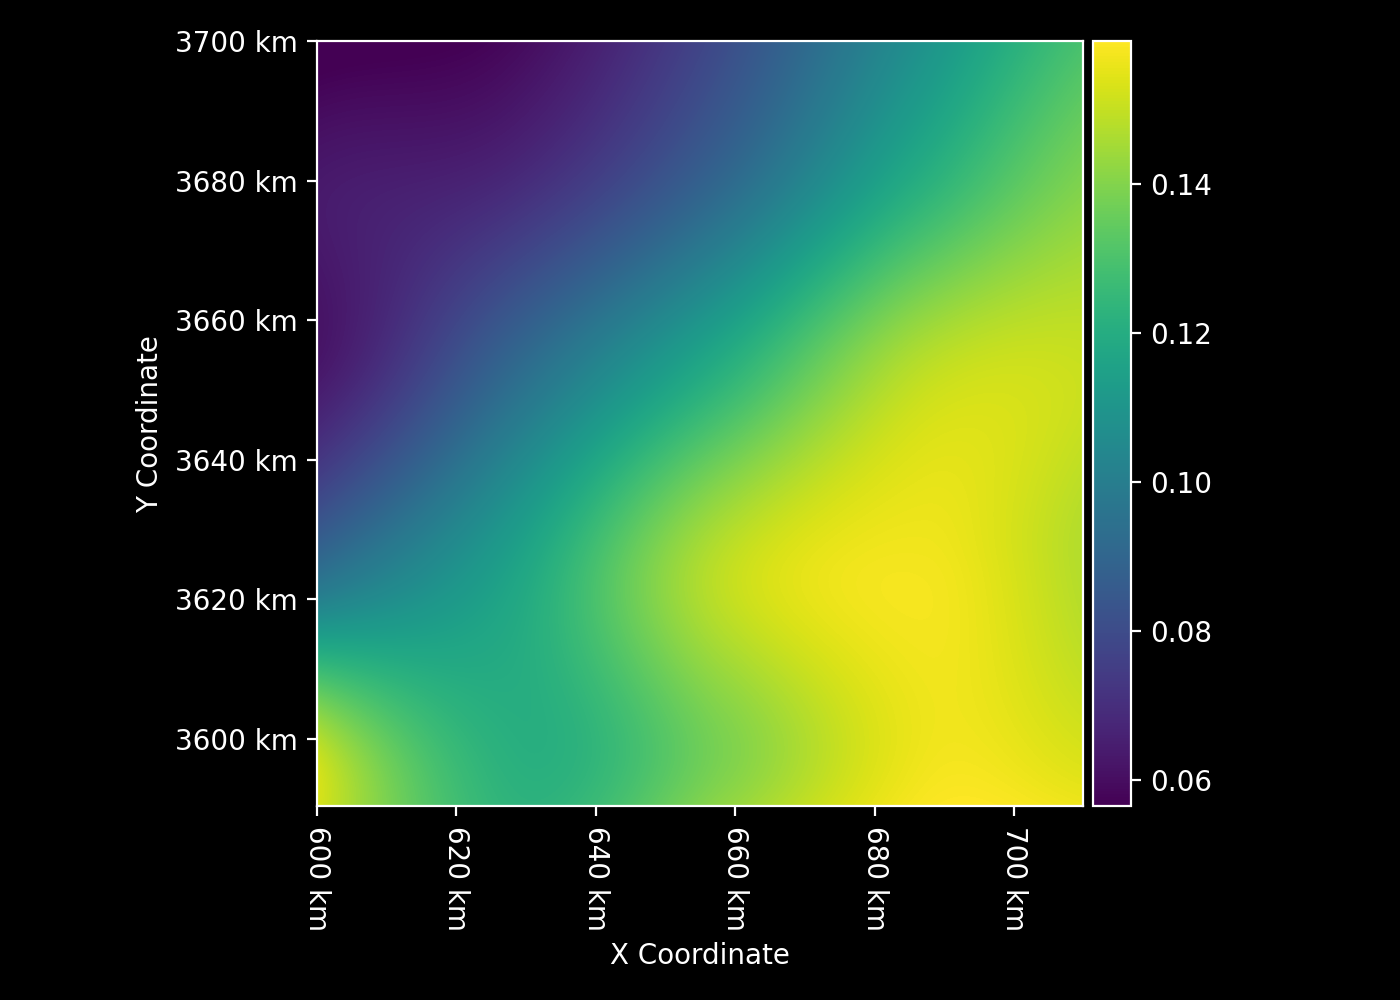

In [7]:
AOT.cmap = "viridis"
AOT

Download COT from GEOS-5 FP.

In [8]:
%%capture
COT = geos5fp.COT(time_UTC=time_UTC, geometry=albedo.geometry)

--2024-09-13 21:36:35--  https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/das/Y2024/M07/D28/GEOS.fp.asm.tavg1_2d_rad_Nx.20240728_2030.V01.nc4
Resolving portal.nccs.nasa.gov (portal.nccs.nasa.gov)... 2001:4d0:2418:2800::a99a:9791, 169.154.151.145
Connecting to portal.nccs.nasa.gov (portal.nccs.nasa.gov)|2001:4d0:2418:2800::a99a:9791|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40212662 (38M) [application/octet-stream]
Saving to: ‘/Users/gregoryhalverson/data/GEOS5FP/GEOS5FP_download_directory/2024.07.28/GEOS.fp.asm.tavg1_2d_rad_Nx.20240728_2030.V01.nc4.20240914043635.download’

     0K .......... .......... .......... .......... ..........  0%  234K 2m48s
    50K .......... .......... .......... .......... ..........  0%  530K 2m1s
   100K .......... .......... .......... .......... ..........  0% 6.01M 83s
   150K .......... .......... .......... .......... ..........  0% 2.20M 66s
   200K .......... .......... .......... .......... ..........  0%  624K 

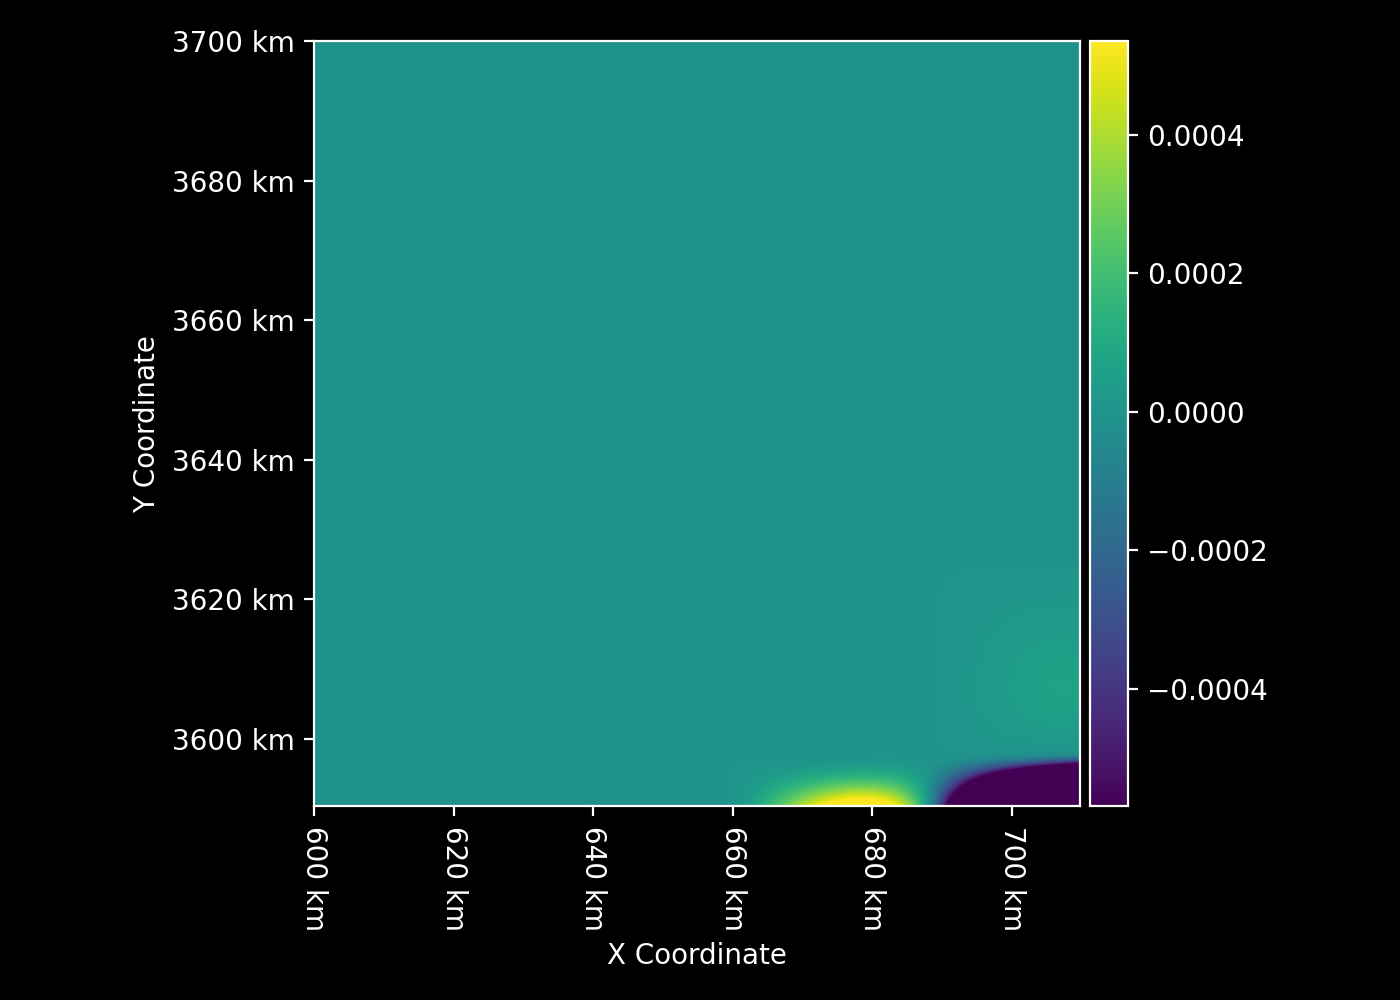

In [9]:
COT.cmap = "viridis"
COT

Download total column water vapor (vapor_gccm) in grams per square centimeter from GEOS-5 FP.

In [10]:
%%capture
vapor_gccm = geos5fp.vapor_gccm(time_UTC=time_UTC, geometry=albedo.geometry)

--2024-09-13 21:36:42--  https://portal.nccs.nasa.gov/datashare/gmao/geos-fp/das/Y2024/M07/D28/GEOS.fp.asm.inst3_2d_asm_Nx.20240728_1800.V01.nc4
Resolving portal.nccs.nasa.gov (portal.nccs.nasa.gov)... 2001:4d0:2418:2800::a99a:9791, 169.154.151.145
Connecting to portal.nccs.nasa.gov (portal.nccs.nasa.gov)|2001:4d0:2418:2800::a99a:9791|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45429146 (43M) [application/octet-stream]
Saving to: ‘/Users/gregoryhalverson/data/GEOS5FP/GEOS5FP_download_directory/2024.07.28/GEOS.fp.asm.inst3_2d_asm_Nx.20240728_1800.V01.nc4.20240914043642.download’

     0K .......... .......... .......... .......... ..........  0%  241K 3m4s
    50K .......... .......... .......... .......... ..........  0%  481K 2m18s
   100K .......... .......... .......... .......... ..........  0% 15.5M 93s
   150K .......... .......... .......... .......... ..........  0%  513K 91s
   200K .......... .......... .......... .......... ..........  0% 6.49M 

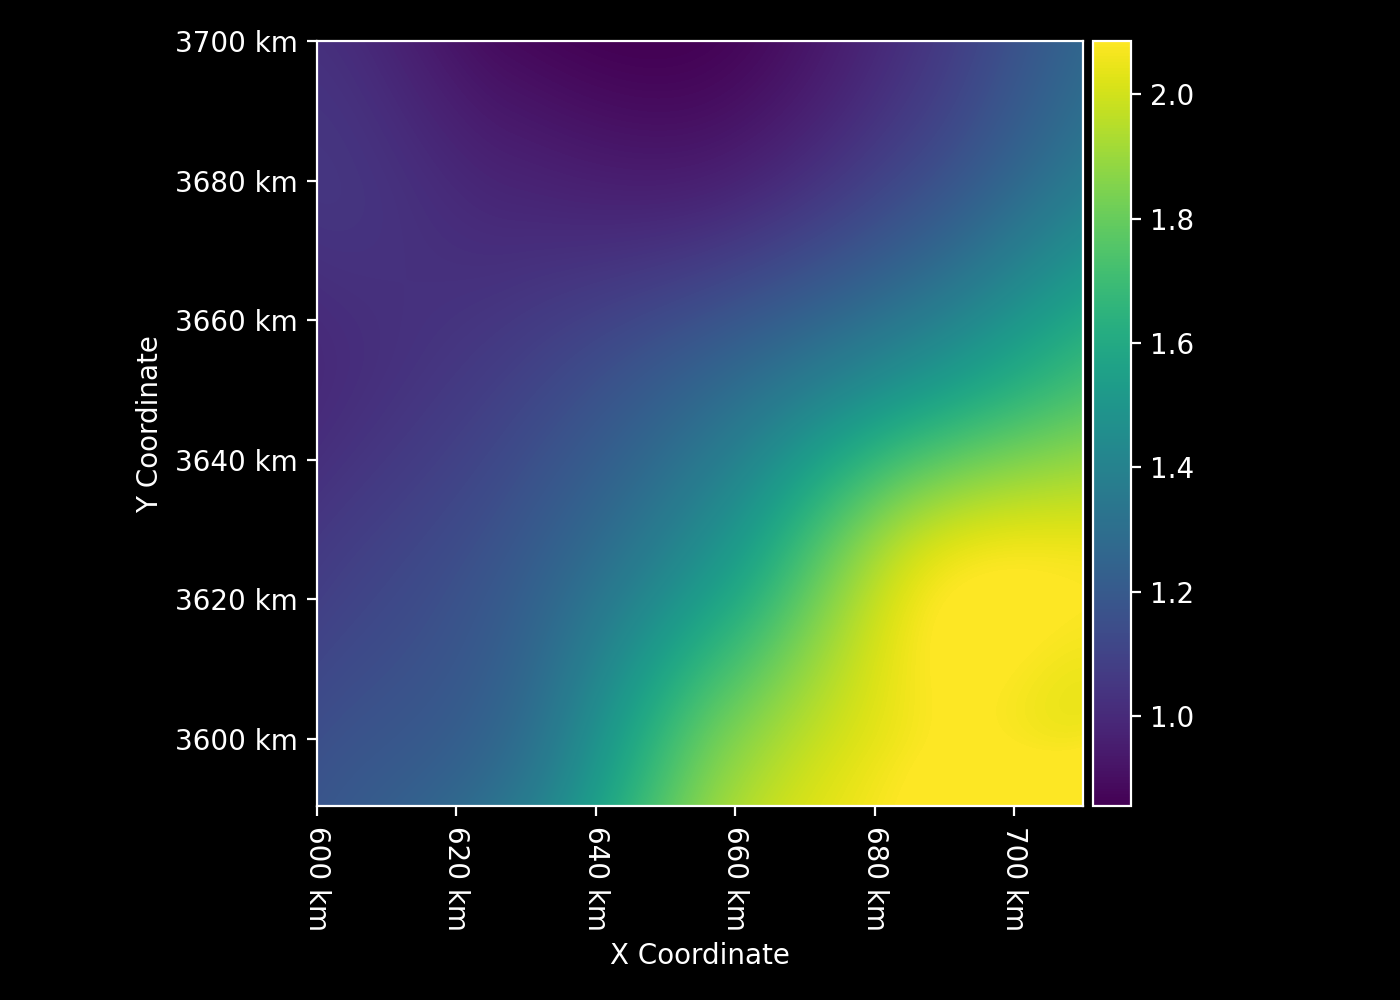

In [11]:
vapor_gccm.cmap = "viridis"
vapor_gccm

Download total column ozone (ozone_cm) in centimeters from GEOS-5 FP.

In [12]:
%%capture
ozone_cm = geos5fp.ozone_cm(time_UTC=time_UTC, geometry=albedo.geometry)

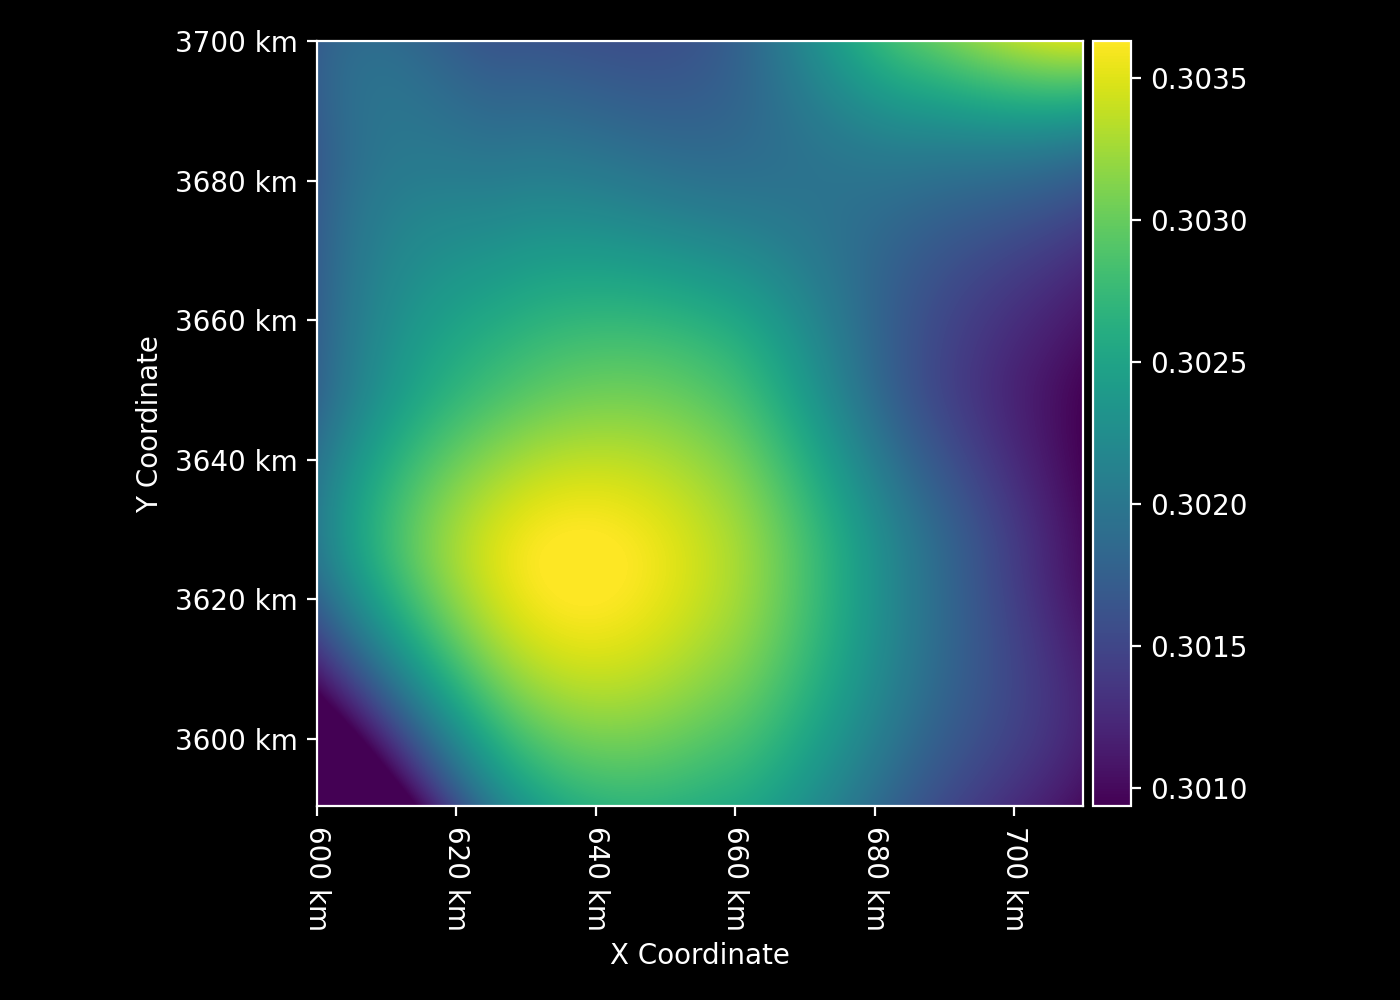

In [13]:
ozone_cm.cmap = "viridis"
ozone_cm

Load the Köppen–Geiger climate classification from the `koppengeiger` package.

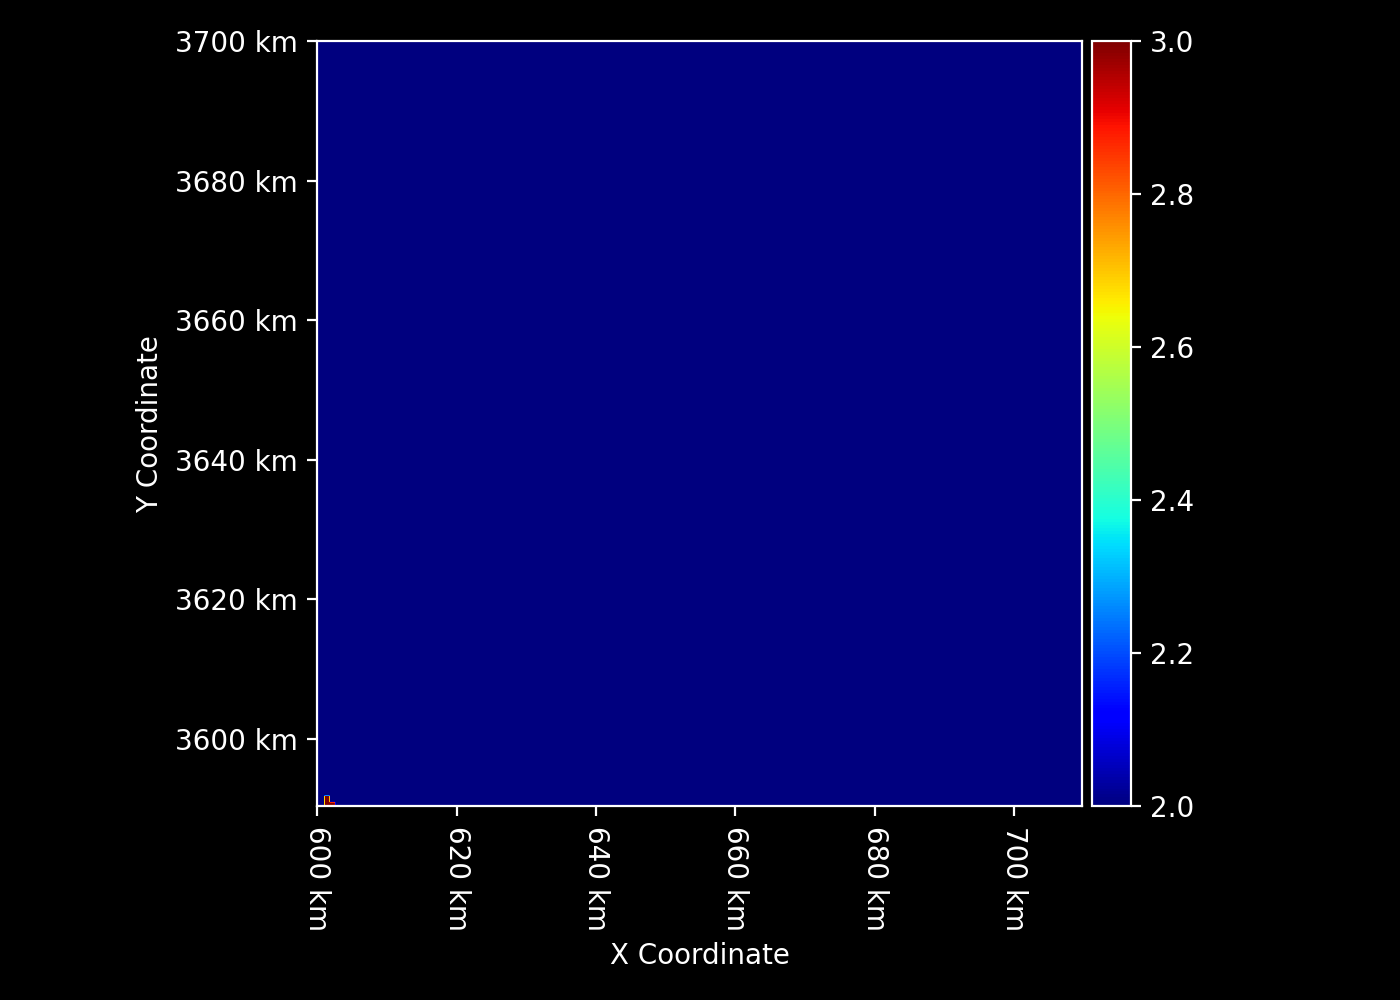

In [14]:
kg = load_koppen_geiger(albedo.geometry)
kg

We'll use the digital elevation model (DEM) provided by ECOSTRESS, which is derived from the Shuttle Radar Topography Mission (SRTM).

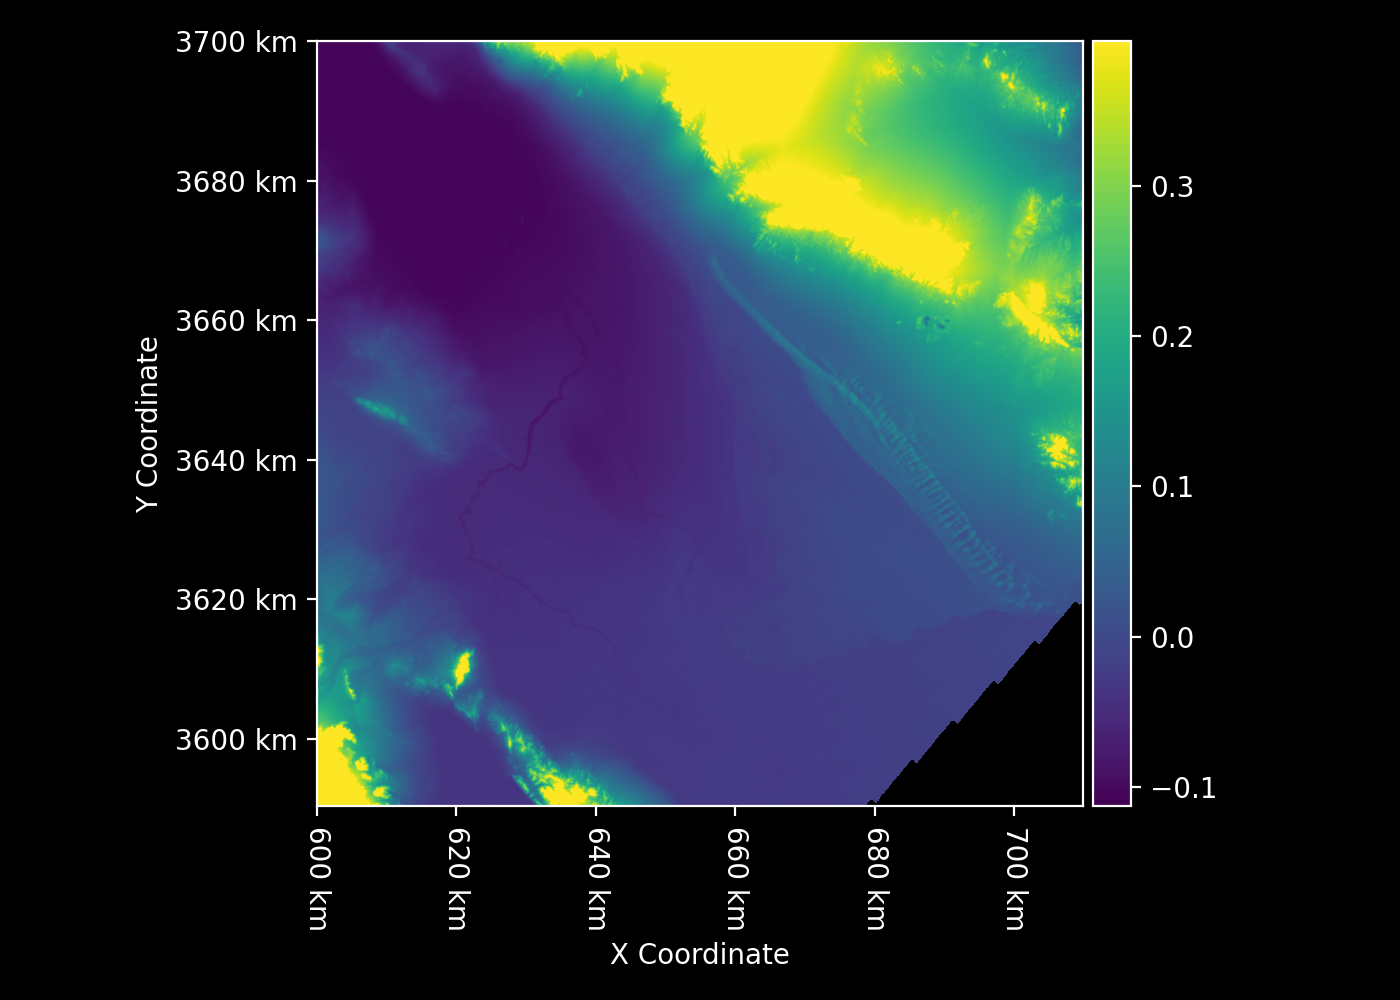

In [15]:
elevation_filename = "ECOv002_L2T_LSTE_34366_004_11SPS_20240728T204025_0712_01_height.tif"
elevation_m = rt.Raster.open(elevation_filename)
elevation_km = elevation_m / 1000
elevation_km.cmap = "viridis"
elevation_km

In [16]:
day_angle_rad = sun_angles.day_angle_rad_from_DOY(doy_solar)
solar_dec_deg = sun_angles.solar_dec_deg_from_day_angle_rad(day_angle_rad)
SZA_deg = sun_angles.SZA_deg_from_lat_dec_hour(ST.geometry.lat, solar_dec_deg, hour_of_day_solar)
SZA_deg

array([[19.58331727, 19.58331273, 19.58330818, ..., 19.57232504,
        19.57231554, 19.57230603],
       [19.58287844, 19.5828739 , 19.58286935, ..., 19.57188673,
        19.57187722, 19.57186772],
       [19.58243962, 19.58243508, 19.58243053, ..., 19.57144842,
        19.57143892, 19.57142941],
       ...,
       [18.90930225, 18.90929804, 18.90929382, ..., 18.89911795,
        18.89910914, 18.89910033],
       [18.90888002, 18.90887581, 18.9088716 , ..., 18.89869624,
        18.89868743, 18.89867863],
       [18.90845781, 18.9084536 , 18.90844938, ..., 18.89827454,
        18.89826574, 18.89825693]])

In [17]:
FLiES_results = process_FLiES(
    doy=doy_solar,
    albedo=albedo,
    COT=COT,
    AOT=AOT,
    vapor_gccm=vapor_gccm,
    ozone_cm=ozone_cm,
    elevation_km=elevation_km,
    SZA=SZA_deg,
    KG_climate=kg
)

76832/76832 [==============================] - 19s 253us/step


/opt/homebrew/Caskroom/mambaforge/base/envs/FLiES/lib/python3.11/site-packages/rasters/rasters.py:4354: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  plt.switch_backend(prior_backend)


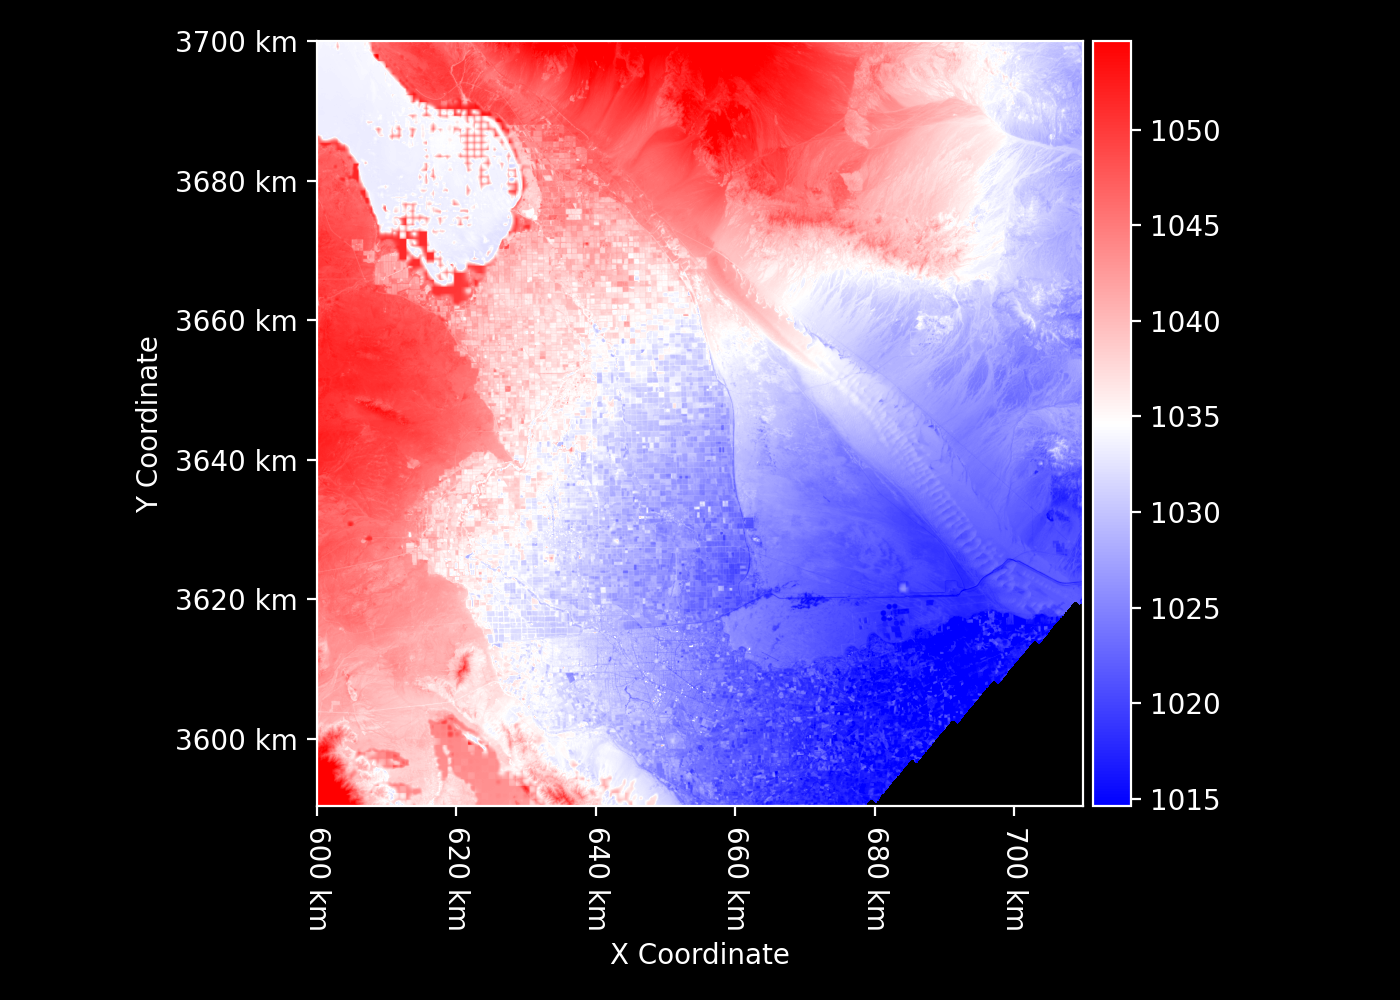

In [19]:
Rg = FLiES_results["Rg"]
Rg.cmap = "bwr"
Rg